In [1]:
# Download data
import os

# Pytoch
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn

# Data science tools
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Timing utility
from timeit import default_timer as timer

# Visualizationsos
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt

import os




In [50]:
#download data
!wget https://github.com/weining20000/Flooding-Damage-Detection-from-Post-Hurricane-Satellite-Imagery-Based-on-CNN/blob/master/Code/satellite-images-of-hurricane-damage.zip

In [9]:

# Input images normalized in the same way and the image H and W are expected to be at least 224
tforms = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),
                             transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
train_tfroms = transforms.Compose([transforms.Resize((128, 128)),transforms.ColorJitter(),
                                   transforms.RandomHorizontalFlip(), transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# Load train image data
traindataFromFolders = datasets.ImageFolder(root = 'train_another/', transform = train_tfroms)
train_loader = DataLoader(traindataFromFolders, batch_size = 100,  shuffle = True)
for x_train, y_train in train_loader:
    pass  


In [12]:
# Load validation image data
valdataFromFolders = datasets.ImageFolder(root = 'validation_another/', transform = tforms)
val_loader = DataLoader(valdataFromFolders,batch_size = 100, shuffle = True)
for x_val, y_val in val_loader:
    pass 


# Load test image data
testdataFromFolders = datasets.ImageFolder(root = 'test_another/', transform = train_tfroms)
test_loader = DataLoader(testdataFromFolders,batch_size = 20, shuffle = False)
for x_test, y_test in test_loader:
    pass  

In [13]:
#=======================================================================================================================
#                                                     Modeling
#=======================================================================================================================
# %% ------------------------------------------------- Set-Up ----------------------------------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# %% ---------------------------------------------- Hyper Parameters ---------------------------------------------------
LR = 0.01
N_EPOCHS = 100
BATCH_SIZE = 25
DROPOUT = 0.5


# %% ---------------------------------------------- Helper Functions ---------------------------------------------------
def acc(x, y, return_labels = False):
    with torch.no_grad():
        logits = model(x)
        pred_labels = np.argmax(logits.cpu().numpy(), axis=1)
    if return_labels:
        return pred_labels
    else:
        return 100*accuracy_score(y.cpu().numpy(), pred_labels)


# %% -------------------------------------------------- CNN Class-------------------------------------------------------
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1)
        self.convnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=6, stride=1, padding=1)
        self.convnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(64, 64, kernel_size = 6, stride = 1, padding = 1)
        self.convnorm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.AvgPool2d((2, 2))

        self.dropout = nn.Dropout(DROPOUT)
        self.linear1 = nn.Linear(64 * 13 * 13, 16)
        self.linear1_bn = nn.BatchNorm1d(16)
        self.linear2 = nn.Linear(16, 2)
        self.linear2_bn = nn.BatchNorm1d(2)
        self.sigmoid = torch.sigmoid
        self.relu = torch.relu

    def forward(self, x):
        x = self.pool1(self.convnorm1(self.relu(self.conv1(x))))
        x = self.pool2(self.convnorm2(self.relu(self.conv2(x))))
        x = self.pool3(self.convnorm3(self.relu(self.conv3(x))))
        # print(x.shape)
        x = self.dropout(self.linear1_bn(self.relu(self.linear1(x.view(-1, 64 * 13 * 13)))))
        x = self.dropout(self.linear2_bn(self.relu(self.linear2(x))))
        x = self.sigmoid(x)
        return x


In [14]:
# %% ------------------------------------------------- Training Prep ---------------------------------------------------
model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

def acc(x, y, return_labels = False):
    with torch.no_grad():
        logits = model(x)
        pred_labels = np.argmax(logits.cpu().numpy(), axis = 1)
    if return_labels:
        return pred_labels
    else:
        return 100*accuracy_score(y.cpu().numpy(), pred_labels)


# %% -------------------------------------------------- Training Loop --------------------------------------------------
print("Starting training loop...")
history_li = []
for epoch in range(N_EPOCHS):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    val_loss = 0.0

    train_acc = 0
    val_acc = 0

    # Set to training
    model.train()
    start = timer()

    loss_train = 0
    model.train()

    for batch in range(len(x_train)//BATCH_SIZE):

        inds = slice(batch*BATCH_SIZE, (batch+1)*BATCH_SIZE)
        optimizer.zero_grad()
        logits = model(x_train[inds])
        loss = criterion(logits, y_train[inds])
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        # Track train loss
        train_loss += loss.item()
        train_acc = acc(x_train, y_train)

    model.eval()

    with torch.no_grad():
        y_val_pred = model(x_val)
        loss = criterion(y_val_pred, y_val)
        val_loss = loss.item()
        val_acc = acc(x_val, y_val)
        loss_test = loss.item()

        history_li.append([train_loss/BATCH_SIZE, val_loss, train_acc, val_acc])
        torch.save(model.state_dict(), 'model_custom.pt')
        torch.cuda.empty_cache()
    print("Epoch {} | Train Loss {:.5f}, Train Acc {:.2f} - Test Loss {:.5f}, Test Acc {:.2f}".format(
        epoch, loss_train/BATCH_SIZE, acc(x_train, y_train), val_loss, acc(x_val, y_val)))

    history = pd.DataFrame(history_li, columns=['train_loss', 'val_loss', 'train_acc', 'val_acc'])


Starting training loop...
Epoch 0 | Train Loss 0.11341, Train Acc 55.00 - Test Loss 0.69322, Test Acc 49.00
Epoch 1 | Train Loss 0.10667, Train Acc 55.00 - Test Loss 0.68336, Test Acc 49.00
Epoch 2 | Train Loss 0.10903, Train Acc 54.00 - Test Loss 0.68073, Test Acc 50.00
Epoch 3 | Train Loss 0.10639, Train Acc 60.00 - Test Loss 0.67782, Test Acc 51.00
Epoch 4 | Train Loss 0.10522, Train Acc 68.00 - Test Loss 0.66695, Test Acc 48.00
Epoch 5 | Train Loss 0.10338, Train Acc 71.00 - Test Loss 0.65096, Test Acc 59.00
Epoch 6 | Train Loss 0.09934, Train Acc 74.00 - Test Loss 0.65309, Test Acc 64.00
Epoch 7 | Train Loss 0.10643, Train Acc 74.00 - Test Loss 0.65387, Test Acc 65.00
Epoch 8 | Train Loss 0.10382, Train Acc 74.00 - Test Loss 0.63928, Test Acc 62.00
Epoch 9 | Train Loss 0.10224, Train Acc 82.00 - Test Loss 0.63467, Test Acc 77.00
Epoch 10 | Train Loss 0.10171, Train Acc 81.00 - Test Loss 0.63618, Test Acc 66.00
Epoch 11 | Train Loss 0.09690, Train Acc 79.00 - Test Loss 0.63640, Tes

Epoch 99 | Train Loss 0.08056, Train Acc 99.00 - Test Loss 0.54269, Test Acc 83.00


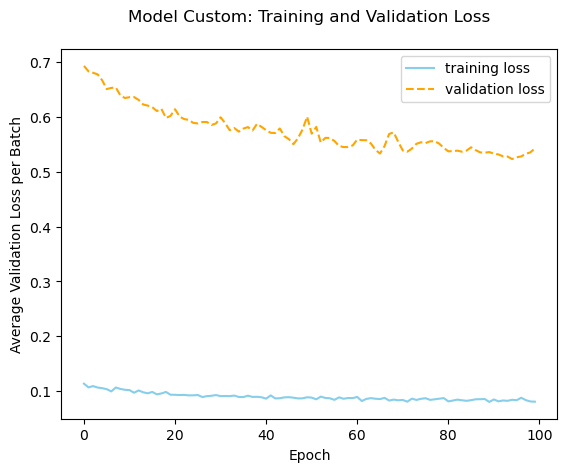

In [15]:
history.to_csv("custom_result.csv")


df_valid_loss = pd.DataFrame({'Epoch': range(0, 100), # Make sure the range is consistent with the Epoch number
                       'valid_loss_train':history['train_loss'],
                       'valid_loss_val': history['val_loss']
                       })

plot1, = plt.plot('Epoch', 'valid_loss_train', data = df_valid_loss, color = 'skyblue')
plot2, = plt.plot('Epoch', 'valid_loss_val', data = df_valid_loss, linestyle = '--', color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Average Validation Loss per Batch')
plt.title('Model Custom: Training and Validation Loss', pad = 20)
plt.legend([plot1, plot2], ['training loss', 'validation loss'])
plt.savefig('Result_Loss_Custom.png')


In [16]:
def predict(mymodel, model_name_pt, loader):

    model = mymodel
    model.load_state_dict(torch.load(model_name_pt))
    model.to(device)
    model.eval()
    y_actual_np = []
    y_pred_np = []
    for idx, data in enumerate(test_loader):
        test_x, test_label = data[0], data[1]
        test_x = test_x.to(device)
        y_actual_np.extend(test_label.cpu().numpy().tolist())

        with torch.no_grad():
            y_pred_logits = model(test_x)
            pred_labels = np.argmax(y_pred_logits.cpu().numpy(), axis=1)
            print("Predicting ---->", pred_labels)
            y_pred_np.extend(pred_labels.tolist())

    return y_actual_np, y_pred_np

y_actual, y_predict = predict(model, "model_custom.pt", test_loader)

Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0]
Predicting ----> [0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
Predicting ----> [1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0]
Predicting ----> [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
Predicting ----> [0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0]
Predicting ----> [1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0]
Predicting ----> [0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 

Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Predicting ----> [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 

Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicting ----> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Predicting ----> [1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1]
Predicting ----> [1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1]
Predicting ----> [1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1]
Predicting ----> [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
Predicting ----> [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1]
Predicting ----> [1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1]
Predicting ----> [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
Predicting ----> [1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1]
Predicting ----> [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Predicting ----> [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicting ----> [1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1]
Predicting ----> [1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1]
Predicting ----> [0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
Predicting ----> [1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1]
Predicting ----> [1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicting ----> [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0]
Predicting ----> [1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 

The Accuracy rate for the model is:  91.3111111111111
[[7451  549]
 [ 233  767]]


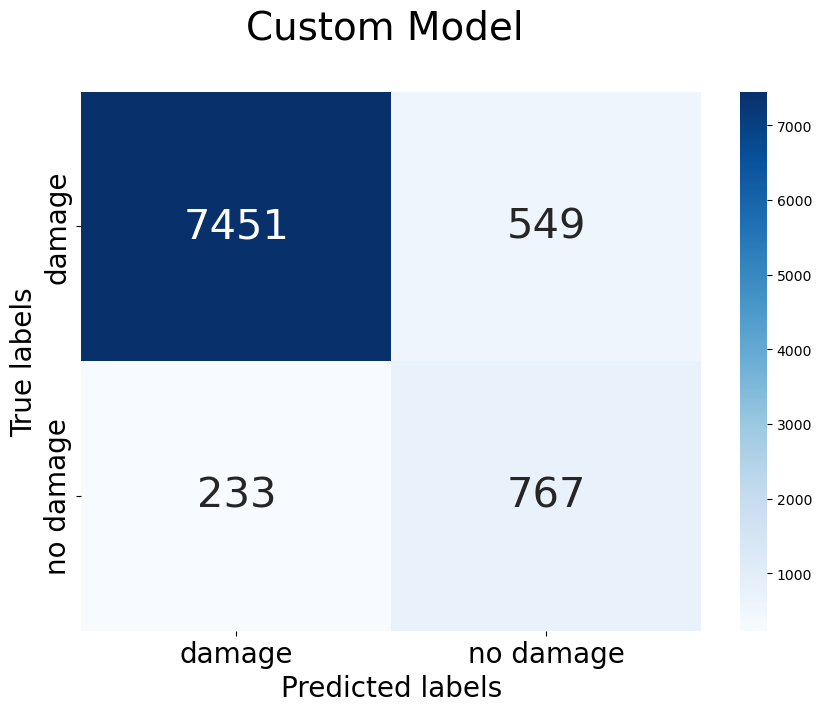

In [17]:
acc_rate = 100*accuracy_score(y_actual, y_predict)
print("The Accuracy rate for the model is: ", acc_rate)
print(confusion_matrix(y_actual, y_predict))

cm = confusion_matrix(y_actual, y_predict)
fig = plt.figure(figsize = (10,7))
ax= plt.subplot()
sns.heatmap(cm, cmap="Blues", annot=True, ax = ax, fmt='g', annot_kws={"size": 30})

# labels, title and ticks
ax.set_xlabel('Predicted labels',fontsize= 20)
ax.set_ylabel('True labels',fontsize= 20)

ax.set_title('Custom Model \n',fontsize= 28)

ax.xaxis.set_ticklabels(['damage', 'no damage'],fontsize= 20)
ax.yaxis.set_ticklabels(['damage', 'no damage'],fontsize= 20)
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))

fig.savefig("Result_Confusion_Matrix_Custom.png")

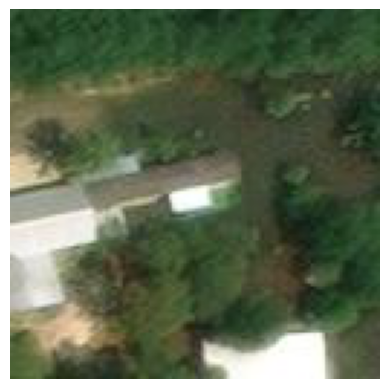

Predicted Label: 0


In [49]:
from PIL import Image  # Import the Image class from the Python Imaging Library (PIL) or Pillow
import matplotlib.pyplot as plt

def predict_single_image(mymodel, model_name_pt, image_path):

    model = mymodel
    model.load_state_dict(torch.load(model_name_pt))
    model.to(device)
    model.eval()

    # Load and preprocess the single image
    image = Image.open(image_path)  # Load the image using a library like PIL
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize the image to match the model's input size
        transforms.ToTensor(),           # Convert to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    test_x = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        y_pred_logits = model(test_x)
        pred_label = torch.argmax(y_pred_logits, dim=1).item()

    return pred_label

# Usage
image_path = "123.jpeg"
image_to_display = Image.open(image_path)

# Display the image
plt.imshow(image_to_display)
plt.axis('off')  # Remove axes
plt.show()
predicted_label = predict_single_image(model, "model_custom.pt", image_path)
print("Predicted Label:", predicted_label)
